```{index} single: Solvers; Mosek
```
```{index} single: Pyomo; kernel library
```
```{index} single: conic optimization
```
```{index} single: application; support vector machines
```
```{index} single: application; binary classification
```
```{index} single: application; counterfeit banknotes
```
# Support Vector Machines Revisited

This notebook revisits the [Support Vector Machines for Binary Classification](../05/svm.ipynb) notebook from Chapter 5, but this time in the context of conic optimization.


In [1]:
# install Pyomo and solvers
import sys
import os

SOLVER_CONIC = "mosek_direct"

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre >/dev/null 2>/dev/null
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'
    
    SOLVER_CONIC = "ipopt"

## The Data Set 

The following data set contains data from a collection of known genuine and known counterfeit banknote specimens. The data includes four continuous statistical measures obtained from the wavelet transform of banknote images named "variance", "skewness", "curtosis", and "entropy", and a binary variable named "class" which is 0 if genuine and 1 if counterfeit.

https://archive.ics.uci.edu/ml/datasets/banknote+authentication

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# read data set
df = pd.read_csv("https://raw.githubusercontent.com/mobook/MO-book/main/datasets/data_banknote_authentication.txt", header=None)
df.columns = ["variance", "skewness", "curtosis", "entropy", "class"]
df.name = "Banknotes"

# create training and validation test sets
df_train, df_test = train_test_split(df, test_size=0.2)

# select training features
features = ["variance", "skewness"]

# separate into features and outputs
X_train = df_train[features]
y_train = 1 - 2 * df_train["class"]

# separate into features and outputs
X_test = df_test[features]
y_test = 1 - 2 * df_test["class"]

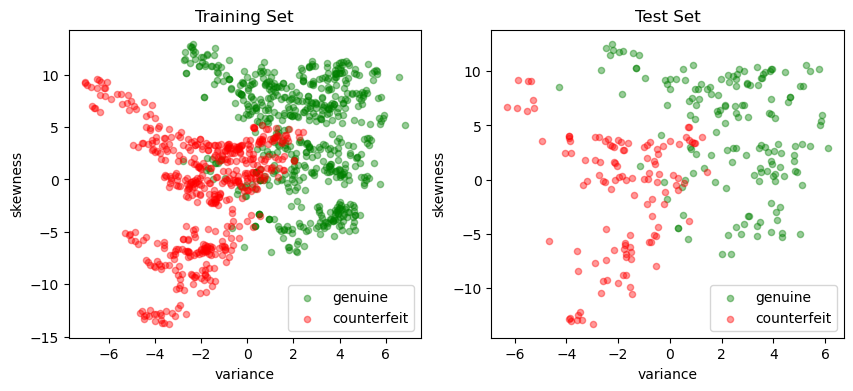

In [3]:
def scatter_labeled_data(X, y, labels=["+1", "-1"], colors=["g", "r"], **kwargs):
    """
    Creates a scatter plot for labeled data with default labels and colors.

    Parameters:
    X : DataFrame
        Feature matrix as a DataFrame.
    y : Series
        Target vector as a Series.
    labels : list, optional
        Labels for the positive and negative classes. Default is ["+1", "-1"].
    colors : list, optional
        Colors for the positive and negative classes. Default is ["g", "r"].
    **kwargs : dict
        Additional keyword arguments for the scatter plot.

    Returns:
    None
    """

    # Prepend keyword arguments for all scatter plots
    kw = {"x": 0, "y": 1, "kind": "scatter", "alpha": 0.4}
    kw.update(kwargs)

    # Ignore warnings from matplotlib scatter plot
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        kw["ax"] = X[y > 0].plot(**kw, c=colors[0], label=labels[0])
        X[y < 0].plot(**kw, c=colors[1], label=labels[1]) 
        

# plot training and test sets in two axes
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
scatter_labeled_data(X_train, y_train, labels = ["genuine", "counterfeit"], ax=ax[0], title="Training Set")
scatter_labeled_data(X_test,  y_test,  labels = ["genuine", "counterfeit"], ax=ax[1], title="Test Set")

## Conic optimization model

### Primal formulation

Following the development of Chapter 5, we again consider training a linear support vector machine using a training set with $p$-element feature vectors $x_i\in\mathbb{R}^p$ ad classification labels, $y_i = \pm 1$. A classifier is defined by two parameters: a weight vector $w\in\mathbb{R}^p$ and a bias term $b\in\mathbb{R}$

$$
\begin{align*}
y^{pred} & = \text{sgn}(w^\top x + b)
\end{align*}
$$

The classifier is trained by developing and solving an optimization model for the values of $w$ and $b$. Introducing slack variables $z_i$ for $i=1, 2, \ldots, n$, 

$$
\begin{align*}
y_i \left( w^\top x_i + b \right) & \geq 1 - z_i& \forall i \in 1, 2, \dots, n
\end{align*}
$$ 

the task is to find $w\in\mathbb{R}^p$ and $b$

$$
\begin{align*}
\min\quad  & \frac{1}{2} \|w \|_2^2 + \frac{c}{n} \sum_{i=1}^n z_i \\
\text{s.t.} \quad &  z_i \geq 1 - y_i(w^\top x_i + b) & \forall i = 1, \dots, n \\
& z_i\geq 0 & \forall i = 1, \dots, n \\
& w\in\mathbb{R}^p \\
& b\in\mathbb{R} \\
\end{align*}
$$

The quadratic term $\frac{1}{2} \|\bar{w}\|_2^2$ is included to regularize the solution for $w$. The parameter $c > 0$ provides for adjusting the tradeoff between reducing the number of misclassifications  versus overfitting a training set. To simplify the presentation of the model, we introduce an $n \times (p+1)$ matrix $F$ constructed from the training data

$$
\begin{align}
    F & = \begin{bmatrix} y_1 x_1^\top \\ y_2 x_2^\top \\ \vdots \\ y_n x_n^\top \end{bmatrix}
\end{align}
$$

Next we introduce a **[rotated quadratic cone](https://docs.mosek.com/modeling-cookbook/cqo.html#equation-eq-sec-qo-modeling-qset2)** defined as 

$$\mathcal{Q}^m_r = \{u\in\mathbb{R}^m | 2u_1u_2 \geq u_3^2 + \cdots + u_m^2,\ u_1, u_2 \geq 0 \}$$

For this application we introduce parameter $r\sim u_1$, let $1\sim u_2$ and $w_k\sim u_{k+2}$. Then

$$2 r \geq \|w\|_2^2 = w_1^2 + w_2^2 + \cdots + w_p^2$$

With these additional components, the problem is now a conic optimization problem ready for implementation with the Pyomo [Kernel Library](https://pyomo.readthedocs.io/en/stable/library_reference/kernel/index.html) and Mosek conic solver.

$$
\begin{align*}
    & \min\ r + \frac{c}{n} 1^\top z\\
    \text{s. t.}\qquad & (r, 1, w) \in \mathcal{Q}_r^{2 + p} \\
    & z + F w + b y \geq 1 \\
    & z \geq 0 & z\in\mathbb{R}^n \\
    & r\in\mathbb{R} \\
    & w\in \mathbb{R}^p \\
    & b\in \mathbb{R}
\end{align*}
$$

Like for the previous case, the Pyomo implementation is a "factory" function that returns a linear SVM.

The following cell presents a simple function to create a scatter plot for a labeled 2D set of features. The function assigns default labels and colors, and passes along other keyword arguments.

In [4]:
# import required libraries
import pandas as pd
import numpy as np

# Linear Support Vector Machine (SVM) class
class LinearSVM:
    # Initialize the Linear SVM with weights and bias
    def __init__(self, w, b):
        """
        Args:
            w (Pandas Series or dictionary): Weights of the SVM
            b (float): Bias of the SVM
        """
        self.w = pd.Series(w)
        self.b = float(b)

    # Call method to compute the decision function
    def __call__(self, X):
        """
        Args:
            X (pandas.DataFrame): Input data

        Returns:
            numpy.array: Array of decision function values
        """
        return np.sign(X.dot(self.w) + self.b)

    # Representation method for the Linear SVM class
    def __repr__(self):
        """
        Returns:
            str: String representation of the Linear SVM
        """
        return f"LinearSvm(w = {self.w.to_dict()}, b = {self.b})"

In [5]:
import pyomo.kernel as pmo

def conicSvmFactory(X, y, c=1):
    
    # create data matrix F
    n, p = X.shape
    F = np.array([y.iloc[i] * np.append(1, X.iloc[i, :].to_numpy()) for i in range(n)])
    
    # create model block
    m = pmo.block()

    # decision variables
    m.r = pmo.variable()
    m.w = pmo.variable_list([pmo.variable() for i in range(p+1)])
    m.z = pmo.variable_list([pmo.variable(lb=0) for i in range(n)])
    
    # objective
    m.primal = pmo.objective(expr = m.r + (c/n) * sum(m.z))
    
    # constraints
    m.qr = pmo.conic.rotated_quadratic.as_domain(m.r, 1, m.w)
    m.d = pmo.constraint_list([pmo.constraint(body=m.z[i] + sum(F[i, j]*m.w[j] for j in range(p+1)), lb=1) for i in range(n)])

    # solve
    pmo.SolverFactory(SOLVER_CONIC).solve(m)
    
    # return svm
    b = m.w[0]()
    w = pd.Series({k: m.w[j+1]() for j, k in enumerate(X.columns)})
    
    return LinearSVM(w, b)

svm_v2 = conicSvmFactory(X_train, y_train, c=10)
print(svm_v2.w)
print(svm_v2.b)

variance    0.538113
skewness    0.156231
dtype: float64
-0.17435734099234473


In [6]:
def scatter_comparison(X, y, y_pred):
    """
    Creates scatter plots comparing actual and predicted outcomes for both training and test sets.

    Parameters:
    X : DataFrame
        Feature matrix as a DataFrame.
    y : Series
        Actual target vector as a Series.
    y_pred : Series
        Predicted target vector as a Series.

    Returns:
    None
    """

    xmin, ymin = X.min()
    xmax, ymax = X.max()
    xlim = [xmin - 0.05 * (xmax - xmin), xmax + 0.05 * (xmax - xmin)]
    ylim = [ymin - 0.05 * (ymax - ymin), ymax + 0.05 * (ymax - ymin)]

    # Plot training and test sets
    labels = ["genuine", "counterfeit"]
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    scatter_labeled_data(X, y, labels, ["g", "r"], ax=ax[0], xlim=xlim, ylim=ylim, title="Actual")
    scatter_labeled_data(X, y_pred, labels, ["c", "m"], ax=ax[1], xlim=xlim, ylim=ylim, title="Prediction")

    # Plot actual positives and actual negatives
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    scatter_labeled_data(X[y > 0], y_pred[y > 0], ["true positive", "false negative"], 
                         ["c", "m"], xlim=xlim, ylim=ylim, ax=ax[0], title="Actual Positives")
    scatter_labeled_data(X[y < 0], y_pred[y < 0], ["false positive", "true negative"], 
                         ["c", "m"], xlim=xlim, ylim=ylim, ax=ax[1], title="Actual Negatives")

    

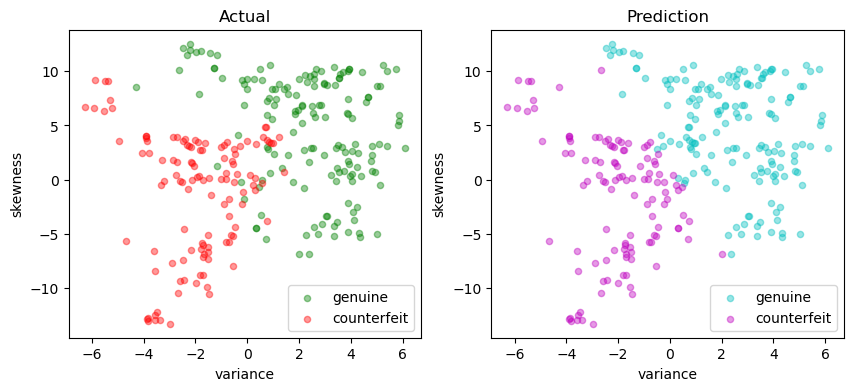

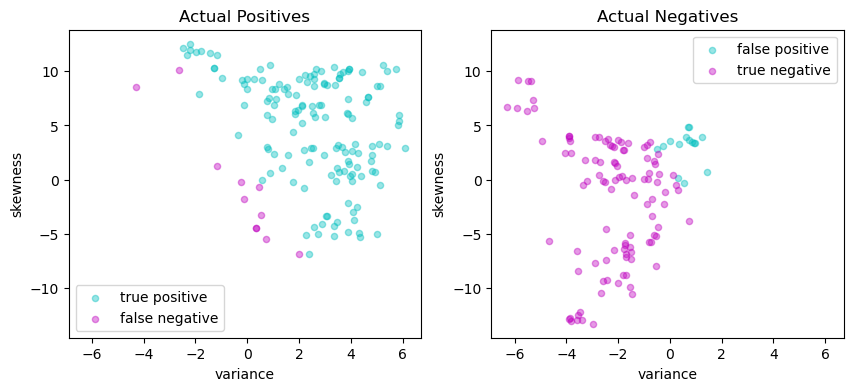

In [7]:
y_pred = svm_v2(X_test)
scatter_comparison(X_test, y_test, y_pred)

### Performance metrics

The following code cell has been was originally presented in [Chapter 5](../05/svm.ipynb).

In [8]:
def validate(y_true, y_pred, verbose=True):
    """
    This function calculates and displays the sensitivity, precision, and Matthews correlation coefficient
    (MCC) for a binary classifier based on its true labels (y_true) and predicted labels (y_pred).
    
    Args:
    y_true (array-like): A list or array containing the true labels of the samples.
    y_pred (array-like): A list or array containing the predicted labels of the samples.
    verbose (bool, optional): If True, the function prints and displays the calculated metrics and 
                              confusion matrix. Defaults to True.
    
    Returns:
    float: The calculated Matthews correlation coefficient (MCC).
    """

    # Calculate the elements of the confusion matrix
    true_positives = sum((y_true > 0) & (y_pred > 0))
    false_negatives = sum((y_true > 0) & (y_pred < 0))
    false_positives = sum((y_true < 0) & (y_pred > 0))
    true_negatives = sum((y_true < 0) & (y_pred < 0))
    total = true_positives + true_negatives + false_positives + false_negatives

    # Calculate the Matthews correlation coefficient (MCC)
    mcc_numerator = (true_positives * true_negatives) - (false_positives * false_negatives)
    mcc_denominator = np.sqrt((true_positives + false_positives) \
                              * (true_positives + false_negatives) \
                              * (true_negatives + false_positives) \
                              * (true_negatives + false_negatives))
    mcc = mcc_numerator / mcc_denominator

    if verbose:
        print(f"Matthews correlation coefficient (MCC) = {mcc:0.3f}")
        
        # report sensitivity and precision, and accuracy
        sensitivity = true_positives / (true_positives + false_negatives)
        precision = true_positives / (true_positives + false_positives)
        accuracy = (true_positives + true_negatives) / total
        
        print(f"Sensitivity = {100 * sensitivity: 0.1f}%") 
        print(f"Precision = {100 * precision: 0.1f}%") 
        print(f"Accuracy = {100 * accuracy: 0.1f}%")

        # Display the binary confusion matrix
        confusion_matrix = pd.DataFrame(
            [[true_positives, false_negatives], [false_positives, true_negatives]], 
            index = ["Actual Positive", "Actual Negative"], 
            columns=["Predicted Positive", "Predicted Negative"])
        display(confusion_matrix)

    return mcc


In [9]:
def test(svm, X_test, y_test):
    y_pred = svm(X_test)
    print(svm, "\n")
    validate(y_test, y_pred)
    scatter_comparison(X_test, y_test, y_pred)

y_pred = svm_v2(X_test)
validate(y_test, y_pred)


Matthews correlation coefficient (MCC) = 0.807
Sensitivity =  92.9%
Precision =  90.6%
Accuracy =  90.5%


,Predicted Positive,Predicted Negative
Actual Positive,145,11
Actual Negative,15,104


0.8070093496995073

### Dual formulation

The following derivation of the dual formulation is an abbreviated version of that given in [Chapter 5](../05/svm.ipynb). A differentiable Lagrangian with dual factors $\alpha_i \geq 0$ and $\beta_i \geq 0$ for $i = 1, \dots, n$, is given by

$$
\begin{align*}
\mathcal{L} & = \frac{1}{2} \|w\|_2^2 + \frac{c}{n}\sum_{i=1}^n z_i + \sum_{i=1}^n \alpha_i \left(1 - z_i y_i (w^\top x_i + b)\right) + \sum_{i=1}^n \beta_i (-z_i) \\
\end{align*}
$$

The necessary conditions for a saddle point are form of a standard quadratic optimization in $n$ variables $\alpha_i$ for $i = 1, \dots, n$.

$$
\begin{align*}
\min_{\alpha_i}\ & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j ( x_i^\top x_j ) -  \sum_{i=1}^n \alpha_i \\
\text{s. t.}\quad & \sum_{i=1}^n \alpha_i y_i = 0  \\
& \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

The symmetric $n \times n$ **Gram matrix** is defined as

$$
    G = \begin{bmatrix} 
        (y_1 x_1^\top)(y_1 x_1) & \dots & (y_1 x_1^\top)(y_n x_n) \\ 
        \vdots & \ddots & \vdots \\ 
        (y_n x_n^\top)(y_1 x_1) & \dots & (y_n x_n^\top)(y_n x_n)
    \end{bmatrix}
$$

where each entry is dot product of two vectors $(y_i x_i), (y_j x_j) \in \mathbb{R}^{p+1}$. We can eliminates the need to compute and store the full Gram matrix $G$ by introducing the $n \times p$ matrix $F$
 
$$
    F = \begin{bmatrix} y_1 x_1^\top \\ y_2 x_2^\top \\ \vdots \\ y_n x_n^\top \end{bmatrix}
$$

Then $G = FF^\top$ which brings the $p$ primal variables $w = F^\top\alpha$ back into the computational problem. The optimization problem becomes

$$
\begin{align*}
\min_{\alpha_i}\ & \frac{1}{2} w^\top w -  1^\top\alpha \\
\text{s. t.}\quad & y^\top\alpha = 0 \\
& w = F^\top\alpha & w\in\mathbb{R}^p \\
& 0 \leq \alpha \leq \frac{c}{n} & \alpha\in\mathbb{R}^n \\
\end{align*}
$$

We introduce an additional decision variable $r \geq 0$ to specify rotated quadratic cones. Then

$$w^\top w \leq 2 r \iff (r, 1, w) \in Q_r^{2 + p}$$

The result is a conic optimization problem for the dual coefficients $\alpha$ and auxiliary variables $r$ and $z$.

$$
\begin{align*}
& \min\ r - 1^\top \alpha\\
\text{s. t.}\quad & y^\top\alpha = 0 \\
& (r, 1, w) \in \mathcal{Q}_r^{2 + p} && r\in\mathbb{R} \\
& w = F^\top \alpha && z\in\mathbb{R}^p \\
& 0 \leq \alpha \leq \frac{c}{n} && \alpha\in\mathbb{R}^n \\
\end{align*}
$$

The solution to dual formulation provides an alternative expression for the resulting support vector machine. Let ${SV}$ represent the set of **support vectors**, which can be implemented as the set of indices for which $\alpha_i > 0$. 
Then SVM can be expressed as either

$$
\begin{align}
y^{pred} & = \text{sgn}\left( \bar{w}^\top \bar{x} \right)\quad
\text{where}\quad \bar{w} = \sum_{i\in\cal{SV}} \alpha_i y_i \bar{x}_i 
\end{align}
$$

or, more directly, as

$$
\begin{align}
y^{pred} & =  \text{sgn}\left( \sum_{i\in\cal{SV}} \alpha_i y_i \bar{x}_i^\top \bar{x} \right)
\end{align}
$$

The first formulation is a computationally efficient implementation of a linear SVM, and used in the following Pyomo implementation. The second formulation, however, provides additional insight into how an SVM works, and is the basis for important generalizations of SVM including the kernelized SVM discussed below.

The solution for the bias term $b$ is obtained by considering the complementarity conditions on the dual variables. The slack variables $z_i$ are zero if $\beta_i > 0$ which is equivalent to $\alpha_i < \frac{c}{n}$. If $\alpha_i > 0$ then $1 - y_i (w^\top x_i + b)$. Putting these facts together gives a formula for $b$

$$
\begin{align}
b & = y_i - w^\top x_i & \forall i\in 1, 2, \ldots, n\quad \text{s.t.}\quad 0 < \alpha_i < \frac{c}{n}\\
\end{align}
$$


### Pyomo implementation

LinearSvm(w = {'variance': 0.5656182473927917, 'skewness': 0.1646042124503589}, b = -0.2726196900769655) 

Matthews correlation coefficient (MCC) = 0.815
Sensitivity =  91.7%
Precision =  92.3%
Accuracy =  90.9%


,Predicted Positive,Predicted Negative
Actual Positive,143,13
Actual Negative,12,107


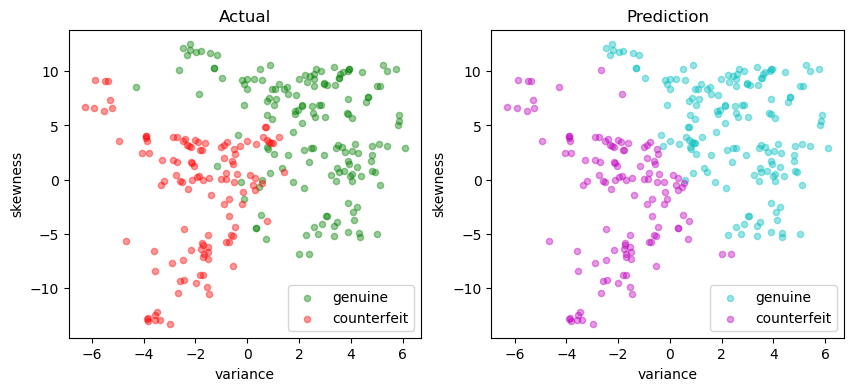

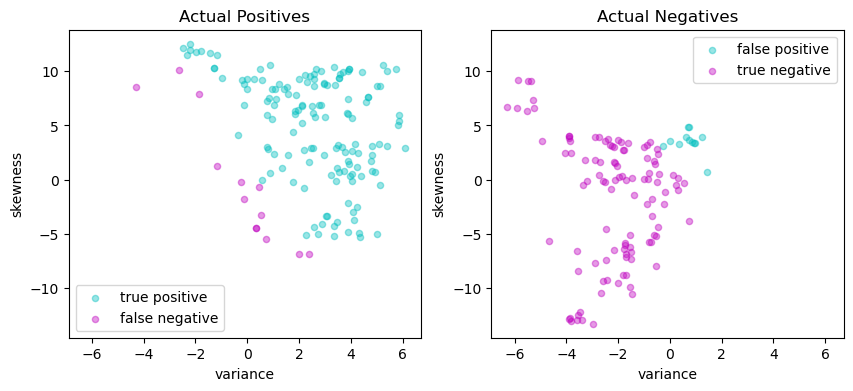

In [10]:
import pyomo.kernel as pmo

def conicDualSVMFactory(X, y, c=1):
    
    n, p = X.shape
    F_ = X.mul(y, axis=0).to_numpy()
    y_ = y.to_numpy()
    C = c / n
    
    m = pmo.block()
    
    # decision variables
    m.r = pmo.variable()
    m.a = pmo.variable_list([pmo.variable(lb=0, ub=C) for i in range(n)])
    m.w = pmo.variable_list([pmo.variable() for i in range(p)])
    
    # objective
    m.o = pmo.objective(expr=m.r - sum(m.a))

    # constraints
    m.s = pmo.constraint(body=sum(y_[i] * m.a[i] for i in range(n)), rhs=0)
    m.d = pmo.constraint_list([
        pmo.constraint(body=sum(F_[i, j]*m.a[i] for i in range(n)) - m.w[j], rhs=0) for j in range(p)
    ]) 
    m.q = pmo.conic.rotated_quadratic.as_domain(m.r, 1, m.w)
    
    # solve
    pmo.SolverFactory(SOLVER_CONIC).solve(m)
    
    # get the support
    S = [i for i in range(n) if (m.a[i]() > 0)]
    
    # create and return linear SVM
    w = pd.Series({k: m.w[j]() for j, k in enumerate(X.columns)})
    a = pd.Series({k: m.a[i]() for i, k in enumerate(X.index)}) 
    
    # Find alpha closest to the center of [0, c/n]
    i = a.index[(a - C / 2).abs().argmin()]
    b = y.loc[i] - X.loc[i, :].dot(w)
    
    y_support = pd.Series([1 if m.a[i]() > 0 else -1 for i in range(n)], index=X.index)
    #scatter(X, y_support, colors=['b', 'y'], labels=['Support Vector', ''], title="Support Vectors")

    return LinearSVM(w, b)

svm_v3 = conicDualSVMFactory(X_train, y_train, c=10)
test(svm_v3, X_test, y_test)


## Kernelized SVM

### Implementation

To take advantage of the kernel trick, we assume an appropriate kernel $K(x, z)$ has been identified, then replace all instances of $\phi(x_i)^\top \phi(x)$ with the kernel. The "kernelized" SVM is then given by solution to 

$$
\begin{align*}
\min_{\alpha_i}\ & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j K(x_i, x_j) -  \sum_{i=1}^n \alpha_i \\
\text{s. t.}\quad & \sum_{i=1}^n \alpha_i y_i = 0 \\
& \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

where

$$
\begin{align}
b & = y_i - \sum_{j=1}^n \alpha_j y_j K(x_j, x_i) & \forall i\in 1, 2, \ldots, n\quad \text{s.t.}\quad 0 < \alpha_i < \frac{c}{n}
\end{align}
$$

where the resulting classifier is given by 

$$y^{pred} = \text{sgn} \left( \sum_{i=1}^n \alpha_i y_i K(x_i, x) + b \right)$$

We define the $n\times n$ positive symmetric semi-definite Gram matrix

$$
G = \begin{bmatrix} 
    y_1 y_1 K(x_1, x_1) & \dots & y_1 y_n K(x_1, x_n) \\ 
    \vdots & \ddots & \vdots \\ 
    y_n y_1 K(x_n, x_1) & \dots & y_n y_n K(x_n, x_n) 
\end{bmatrix}
$$


We factor $G = FF^\top$ where $F$ has dimensions $n \times q$ and where $q$ is the rank of $G$. This factorization is not unique. As demonstrated in the Python code below, one suitable factorization is the spectral factorization $G = U\Lambda U^T$ where $\Lambda$ is a $q\times q$ diagonal matrix of non-zero eigenvalues, and $U$ is an $n\times q$ normal matrix such that $U^\top U = I_q$. Then

$$F = U\Lambda^{1/2}$$

Once this factorization is complete, the optimization problem for the kernelized SVM is the same as for the linear SVM in the dual formulation

$$
\begin{align*}
\min\ & \frac{1}{2} \alpha^\top F F^\top \alpha -  1^\top \alpha \\
\text{s. t.}\quad & \sum_{i=1}^n \alpha_i y_i = 0 \\
& 0 \leq \alpha \leq \frac{c}{n} & \alpha\in\mathbb{R}^n \\
\end{align*}
$$

The result is a conic optimization problem for the dual coefficients $\alpha$ and auxiliary variables $r$ and $z$.

$$
\begin{align*}
& \min\ r - 1^\top \alpha\\
\text{s. t.} \qquad & y^\top\alpha = 0 \\
& (r, 1, z) \in \mathcal{Q}_r^{2 + q} && r\in\mathbb{R} \\
& z = F^\top \alpha && z\in\mathbb{R}^{q} \\
& 0 \leq \alpha \leq \frac{c}{n} && \alpha\in\mathbb{R}^n \\
\end{align*}
$$

Summarizing, the essential difference between training the linear and kernelized SVM is the need to compute and factor the Gram matrix. The result will be a set of non-zero coefficients $\alpha_i > 0$ the define a set of support vectors $\mathcal{SV}$. The classifier is then given by

$$y^{pred} = \text{sgn} \left( \sum_{i\in\mathcal{SV}} \alpha_iK(x_i, x) + b \right)$$

The following cell implements this model, then tests the resulting classifier for some well-known kernels commonly used in SVM applications.

In [11]:
import numpy as np
import pyomo.kernel as pmo


def kernelSVMFactory(X, y, c, tol=1e-8, kernel=lambda x, z: (x @ z)):
    
    n, p = X.shape
    
    # convert to numpy arrays for speed
    X_ = X.to_numpy()
    y_ = y.to_numpy()
    C = c / n
    
    # kernel matrix
    G = [[y_[i] * y_[j] * kernel(X_[i, :], X_[j, :]) for j in range(n)] for i in range(n)]
    
    # spectral factors for a positive semi-definite matrix
    eigvals, V = np.linalg.eigh(G)
    idx = (eigvals >= tol * max(eigvals))
    F = V[:, idx] @ np.diag(np.sqrt(eigvals[idx]))
    q = sum(idx)

    # build model
    m = pmo.block()
    
    # decision variables
    m.r = pmo.variable()
    m.a = pmo.variable_list([pmo.variable(lb=0, ub=C) for i in range(n)])
    m.z = pmo.variable_list([pmo.variable() for i in range(q)])
    
    # objective
    m.o = pmo.objective(expr=m.r - sum(m.a))

    # constraints
    m.s = pmo.constraint(body=sum(y_[i] * m.a[i] for i in range(n)), rhs=0)
    m.d = pmo.constraint_list([pmo.constraint(body=sum(F[i, j]*m.a[i] for i in range(n)) - m.z[j], rhs=0) for j in range(q)]) 
    m.q = pmo.conic.rotated_quadratic.as_domain(m.r, 1, m.z)
    
    # solve
    pmo.SolverFactory(SOLVER_CONIC).solve(m)
    
    # get the support
    SV = [i for i in range(n) if (m.a[i]() > 1e-3*C)]
    
    # create and return linear SVM
    a = np.array([m.a[i]() for i in range(n)])
    
    # Find alpha closest to the center of [0, c/n]
    i = np.abs(a - C / 2).argmin()
    b = y_[i] - sum(a[j] * kernel(X_[j, :], X_[i, :]) for j in range(n))
    
    # get indices of the support vectors
    SV = [i for i in range(n) if (m.a[i]() > 1e-3)]
    
    def kernelSVM(Z):
        nz, pz = Z.shape
        Z_ = Z.to_numpy()
        y_pred = pd.Series([np.sign(sum(m.a[i]() * y_[i] * kernel(X_[i, :], Z_[j, :]) for i in SV)) for j in range(nz)], index=Z.index)
        return y_pred

    return kernelSVM

### Linear kernel

A linear kernel reduces the kernelized SVM to the previous case. 

$$K(x, z) = x^\top z$$

This is useful for verifying the calculation.

<function kernelSVMFactory.<locals>.kernelSVM at 0x7f9250dc44c0> 

Matthews correlation coefficient (MCC) = 0.786
Sensitivity =  94.9%
Precision =  87.6%
Accuracy =  89.5%


,Predicted Positive,Predicted Negative
Actual Positive,148,8
Actual Negative,21,98


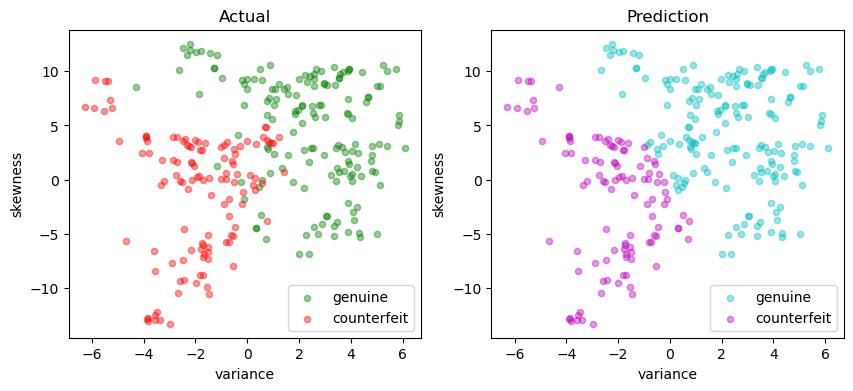

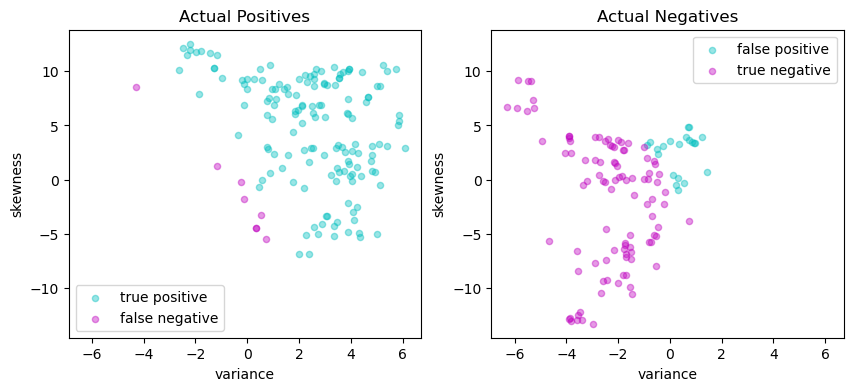

In [12]:
svm = kernelSVMFactory(X_train, y_train, c=10, kernel=lambda x, z: x @ z)

test(svm, X_test, y_test)

### Radial basis function kernel

A radial basis function kernal is given by

$$K(x, z) = \exp\left(-\gamma \|x - z\|^2\right)$$

The radial basis function is commonly used as the default kernel in SVM applications.

<function kernelSVMFactory.<locals>.kernelSVM at 0x7f92389d0700> 

Matthews correlation coefficient (MCC) = 0.912
Sensitivity =  94.9%
Precision =  97.4%
Accuracy =  95.6%


,Predicted Positive,Predicted Negative
Actual Positive,148,8
Actual Negative,4,115


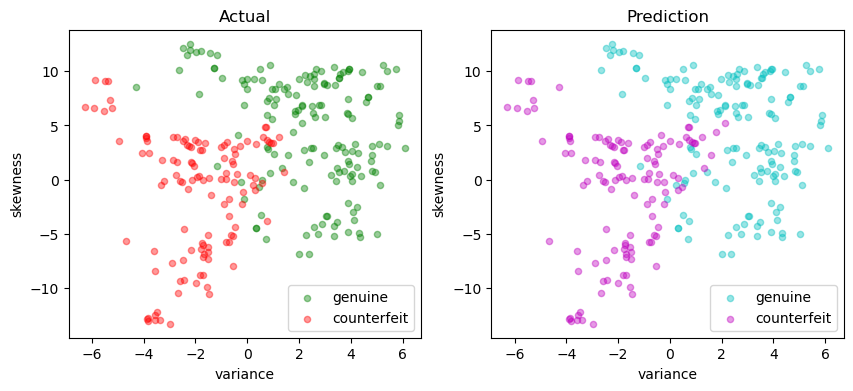

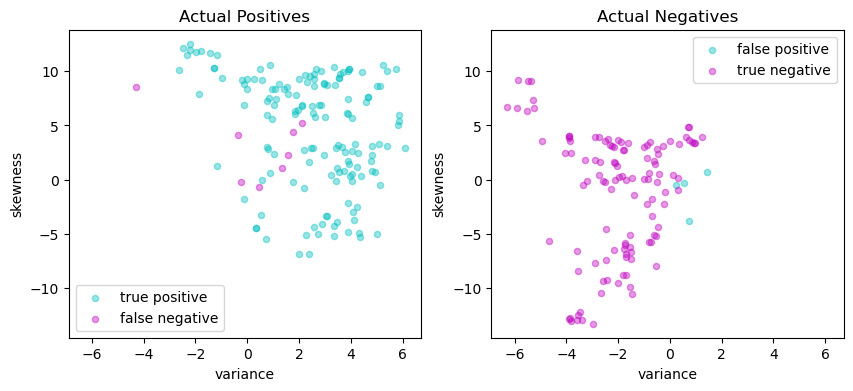

In [15]:
try:
    rbf = lambda x, z: np.exp(-10 * np.linalg.norm(x - z)**2)
    svm = kernelSVMFactory(X_train, y_train, c=10, kernel=rbf)
    test(svm, X_test, y_test)
except:
    print(f"{SOLVER_CONIC} failed")

### Polynomial kernel

$$K(x, z) = (1 + x^\top z)^d$$

<function kernelSVMFactory.<locals>.kernelSVM at 0x7f921cff6040> 

Matthews correlation coefficient (MCC) = -0.057
Sensitivity =  39.7%
Precision =  53.4%
Accuracy =  46.2%


,Predicted Positive,Predicted Negative
Actual Positive,62,94
Actual Negative,54,65


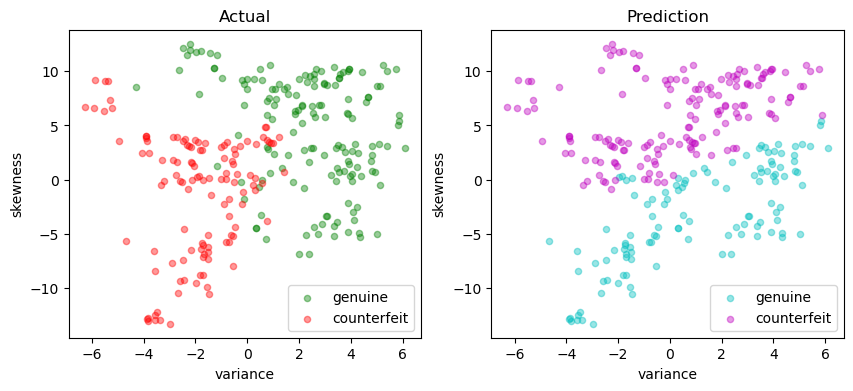

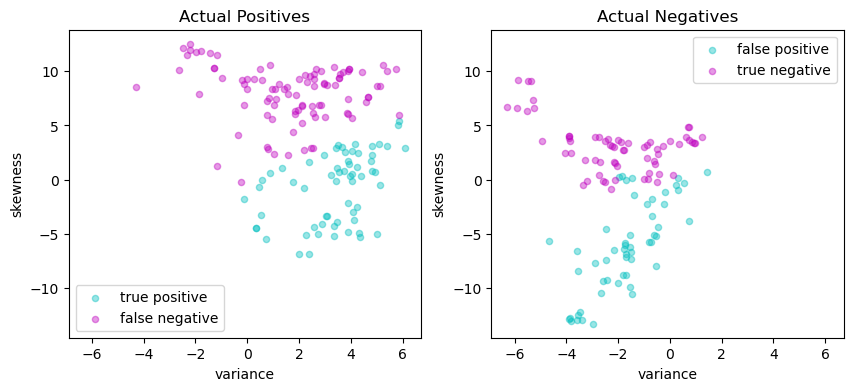

In [14]:
try:
    poly = lambda x, z: (1 + (x @ z)) ** 3
    svm = kernelSVMFactory(X_train, y_train, c=10, kernel=poly)
    test(svm, X_test, y_test)
except:
    print(f"{SOLVER_CONIC} failed")

## Bibliographic Notes

The development of support vector machines is largely attributed to Vladimir Vapnik and colleagues at AT&T Bell Laboratories during the 1990's. The seminal papers are highly readable and entry points to the literature.

> Boser, B. E., Guyon, I. M., & Vapnik, V. N. (1992, July). A training algorithm for optimal margin classifiers. In Proceedings of the fifth annual workshop on Computational learning theory (pp. 144-152).  https://dl.acm.org/doi/10.1145/130385.130401

> Cortes, C., & Vapnik, V. (1995). Support-vector networks. Machine learning, 20(3), 273-297. https://link.springer.com/content/pdf/10.1007/bf00994018.pdf

Support vector machines are a widely used method for supervised machine learning and described in tutorial blog postings and trade journal articles. Representative examples include 

> Sachin, D. N. (2020). Support Vector Machines with Amazon Food Reviews https://medium.com/analytics-vidhya/support-vector-machines-with-amazon-food-reviews-9fe0428e09ef

> http://www.adeveloperdiary.com/data-science/machine-learning/support-vector-machines-for-beginners-linear-svm/

Additional web resources are available at [Wikipedia](https://en.wikipedia.org/wiki/Kernel_method), [CMU](https://www.cs.cmu.edu/~aarti/Class/10315_Fall20/lecs/svm_dual_kernel.pdf), and [Oxford](https://www.robots.ox.ac.uk/~az/lectures/ml/lect3.pdf).
